In [1]:
from matplotlib import pyplot as plt
import numpy as np
import importlib

In [2]:
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard

In [3]:
params = {
    "R" : 1.0,
    "Rz" : 0.01,
    "eccentricity": 0.1,
    "energy": 1,
    "mass": 1,
    "sigma":0.1,
    "sigma_grid":0.5,
    "position_random_shift_percentage": 0.1/100,
    "epsilon":1
}
e = params["eccentricity"]
params.update({
    "abc": np.array(
        [params["R"] / (1-e**2)**(1/4),
        params["R"] * (1-e**2)**(1/4),
        params["Rz"]]
    )
})

In [7]:
sim = SimulatorLennard(**params)
r_init, v_init = sim.init_positions_velocities(**params)
sim.particle_number()

22

In [8]:
history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="EULER"))
history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="RK"))
history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="VERLET"))

100%|██████████| 99999/99999 [00:10<00:00, 9394.97it/s]


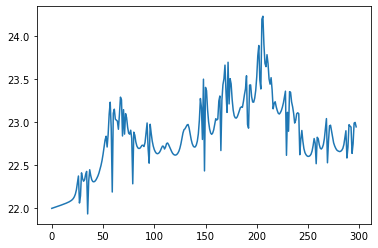

In [9]:
plt.plot(np.sum(history["KE"] + history["PE"], axis=1))